In [1]:
#!jupyter nbconvert --to script Keras_Sentence_RNN.ipynb
import preprocessing
import numpy as np

/home/thongnbui/anaconda2/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
Using TensorFlow backend.


In [2]:
import collections

sentence_max_threshold = 50000
tokenizer, max_sentence_len_word, labels, train_X, test_X, train_y, test_y = preprocessing.get_data(sentence_max_threshold)
print train_X.shape, train_y.shape, len(tokenizer.word_counts)#, len(tokenized_text)

x_count = collections.Counter()
for i in range(len(test_y)):
    x_count.update({str(test_y[i]): 1})

for key, value in sorted(x_count.iteritems(), reverse=True):
    print key, value, float(value)/sentence_max_threshold


Loaded 47 speeches for 14 presidents.
Loaded 1764 speeches for 15 presidents.

How many speeches per president?
0  : Barack Obama         	148
1  : Donald J. Trump      	22
2  : Dwight D. Eisenhower 	194
3  : Franklin D. Roosevelt 	224
4  : George Bush          	98
5  : George W. Bush       	56
6  : Gerald R. Ford       	40
7  : Harry S. Truman      	302
8  : Herbert Hoover       	268
9  : Jimmy Carter         	60
10 : John F. Kennedy      	64
11 : Lyndon B. Johnson    	135
12 : Richard Nixon        	41
13 : Ronald Reagan        	48
14 : William J. Clinton   	64

Approximately many words of text per president?
0  : Barack Obama         	860977
1  : Donald J. Trump      	101328
2  : Dwight D. Eisenhower 	567639
3  : Franklin D. Roosevelt 	323789
4  : George Bush          	346032
5  : George W. Bush       	323772
6  : Gerald R. Ford       	124695
7  : Harry S. Truman      	368810
8  : Herbert Hoover       	138249
9  : Jimmy Carter         	224639
10 : John F. Kennedy      	239684
11 : Ly

### Use Keras_Sentence_RNN.py to avoid time-out problem
If the trained model runs too long, it will time out. To get around this issue, you can skip the run here and instead use Keras_Sentence_RNN.py to train and save the model, then load the saved model here to predict the data.


In [3]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Embedding, SimpleRNN, Dropout
from keras.utils import plot_model
from keras.callbacks import EarlyStopping

max_features = len(tokenizer.word_counts) + 1 # + 1 is for padded word id 0s
batch_size = 100
num_of_nodes = 100 #max_sentence_len_word

print('Build model...')
model = Sequential()
model.add(Embedding(max_features, num_of_nodes, input_length=max_sentence_len_word, dropout=Dropout(0.5)))
model.add(SimpleRNN(num_of_nodes,activation='tanh', dropout=Dropout(0.5)))
#model.add(Dropout(0.5))
model.add(Dense(len(labels), activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='Adagrad',metrics=['categorical_accuracy'])
print(model.summary())

plot_model(model, to_file='Keras_Sentence_RNN.png', show_shapes=True, show_layer_names=True)

#stopping = EarlyStopping(patience=2, verbose=1)

#model.fit(train_X, y=train_y, batch_size=batch_size, nb_epoch=30, verbose=1, class_weight='auto')
model.fit(train_X, train_y, batch_size=batch_size, epochs=40, verbose=1)
#          validation_data=(test_X, test_y), 
#          callbacks=[stopping])

Build model...


/home/thongnbui/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:12: UserWarning: The `dropout` argument is no longer support in `Embedding`. You can apply a `keras.layers.SpatialDropout1D` layer right after the `Embedding` layer to get the same behavior.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 251, 100)          3426200   
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 100)               20100     
_________________________________________________________________
dense_1 (Dense)              (None, 15)                1515      
Total params: 3,447,815
Trainable params: 3,447,815
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/40
  7800/199597 [>.............................] - ETA: 473s - loss: 2.6007 - categorical_accuracy: 0.1509

KeyboardInterrupt: 

In [15]:
from keras.models import load_model

# Load the model you trained Keras_Sentence_RNN.py here to predict on test data
#model.save('rnn.h5')  
model = load_model('rnn.h5')

In [16]:
# Evaluate performance
print "Evaluating test data..."
loss_and_metrics = model.evaluate(test_X, test_y)
print model.metrics_names
print loss_and_metrics

# Make some predictions
print "\nPredicting using test data..."
pred_y = model.predict(test_X, batch_size=batch_size, verbose=1)
pred_y_collapsed = np.argmax(pred_y, axis=1)
test_y_collapsed = np.argmax(test_y, axis=1)

# Get prediction probability
print "Done prediction."

from sklearn import metrics
print "\nAUC = ", metrics.roc_auc_score(test_y, pred_y)

Evaluating test data...
49888/49900 [============================>.] - ETA: 0s  

In [17]:
# from scikit-learn examples @
# http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html 
%matplotlib inline
import itertools
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    #plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Compute confusion matrix
cnf_matrix = confusion_matrix(test_y_collapsed, pred_y_collapsed)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
#plt.figure(figsize=(10,10))
#plot_confusion_matrix(cnf_matrix, classes=(sorted(labels, key=labels.get)),
#                      title='Confusion matrix, without normalization')

# #Plot normalized confusion matrix
# plt.figure(figsize=(10,10))
# plot_confusion_matrix(cnf_matrix, classes=(sorted(labels, key=labels.get)), normalize=True,
#                       title='Normalized confusion matrix')

plt.show()

Confusion matrix, without normalization


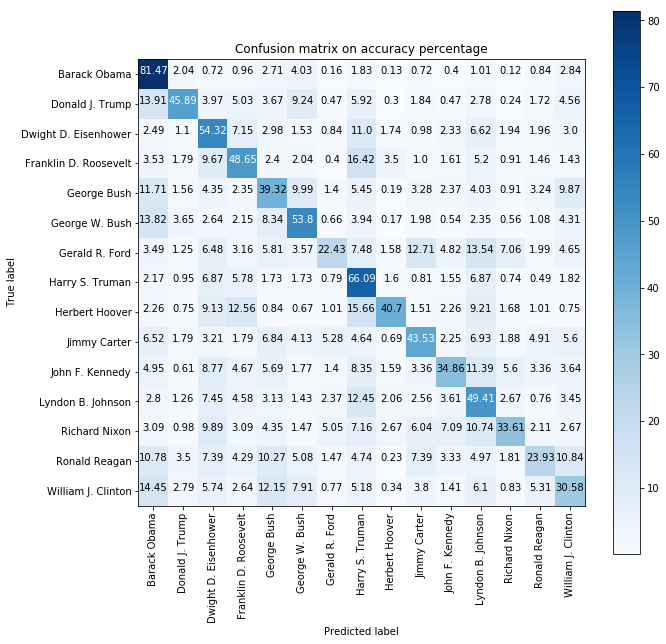

In [18]:
cnf_matrix_pct = cnf_matrix *1.0
cnf_matrix_pct = np.around(np.array([row*100.0/sum(row) for row in cnf_matrix_pct]), 2)

plt.figure(figsize=(10,10))
plot_confusion_matrix(cnf_matrix_pct, classes=(sorted(labels, key=labels.get)),
                      title='Confusion matrix on accuracy percentage')

plt.show()

## Error samples

In [19]:
def reverse_map(map):
    return dict((v,k) for k,v in map.iteritems())

def to_words(a):
    return " ".join([token_word_map[id] for id in a if id != 0])

def print_row(row, col_width=12):
    print "".join(col.ljust(col_width) for col in row)

sample_size = 40

token_word_map = reverse_map(tokenizer.word_index)
president_map = reverse_map(labels)

def get_president(index):
    name = president_map[index]
    arr = name.split(" ")
    if name == "George W. Bush":
        return "W. Bush"
    else:
        return arr[len(arr)-1]
            
# Get error sample data, their sentence length's frequencies and their probabilities to plot later
error_samples = []
error_probability = []
err_sent_count = {}
err_length_prob = {}
correct_sent_count = {}
for i in range(len(test_y_collapsed)):
    sentence = to_words(test_X[i])
    if (pred_y_collapsed[i] != test_y_collapsed[i]):
        cnt = err_sent_count.get(len(sentence), 0)
        err_sent_count[len(sentence)] = cnt + 1
        
        arr = err_length_prob.get(len(sentence), None)
        if (arr == None):
            err_length_prob[len(sentence)] = [pred_y[pred_y_collapsed[i]].max()]
        else:
            err_length_prob[len(sentence)] += [pred_y[pred_y_collapsed[i]].max()]
            
        error_probability = pred_y[pred_y_collapsed[i]]
        error_samples += [[get_president(pred_y_collapsed[i]), get_president(test_y_collapsed[i]), sentence]] 
    else:
        cnt = correct_sent_count.get(len(sentence), 0)
        correct_sent_count[len(sentence)] = cnt + 1

count = 0
min_sentence_length = 20
print_row(["Predicted","Correct","Sentence"])
print_row(["----------","----------","---------------"])
for row in error_samples:
    sentence = row[2]
    if count < sample_size and len(sentence) > min_sentence_length:
        print_row(row)
        count += 1

Predicted   Correct     Sentence    
----------  ----------  ---------------
Bush        Nixon       i think it is a question of timeliness
Truman      Eisenhower  there was no offer made to the peruvians
Johnson     Roosevelt   they cannot get credit and private capital won't give them credit i am not saying improperly
Johnson     Carter      we are increasing every year the allocation of funds for that purpose
Carter      Ford        in order to get new york city to restore their credibility in the money markets they have taken these steps which have eliminated 3 95 billion cash deficit
Johnson     Truman      second the smaller amount of new obligational authority which i am recommending indicates the substantial portion of the financial requirements for our military buildup that has been met in the appropriations already made by the congress
Bush        Carter      and i would hope that from now on after this news conference that we could leave out references to allegations that an

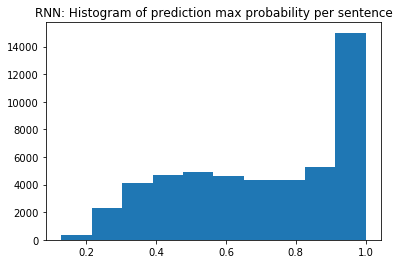

In [20]:
plt.hist(pred_y.max(axis=1))
plt.title('RNN: Histogram of prediction max probability per sentence')
plt.show()

In [10]:
'''
plt.figure(figsize=(7,5)) 

plt.hist(pred_y, label=president_map.values())
plt.legend(prop={'size': 8})
plt.show()

pred_y_t = pred_y.transpose()
print president_map.values()

for i in range(len(pred_y_t)):
    president_pred_prob = pred_y_t[i]
    plt.hist(president_pred_prob, bins=8)
    plt.title("histogram for " + president_map[i])
    plt.show()
    
# Plotting errored sentence length's frequencies and their probabilities
import matplotlib.pyplot as plt

err = plt.scatter(err_sent_count.keys(),err_sent_count.values(),color=['red'])
cor = plt.scatter(correct_sent_count.keys(),correct_sent_count.values(),color=['blue'])
plt.legend((err, cor), ('wrong prediction', 'correct prediction'))
plt.xlabel('sentence length')
plt.ylabel('frequency')
plt.title('LSTM: sentence length vs error frequency')
plt.show()

'''

'\nplt.figure(figsize=(7,5)) \n\nplt.hist(pred_y, label=president_map.values())\nplt.legend(prop={\'size\': 8})\nplt.show()\n\npred_y_t = pred_y.transpose()\nprint president_map.values()\n\nfor i in range(len(pred_y_t)):\n    president_pred_prob = pred_y_t[i]\n    plt.hist(president_pred_prob, bins=8)\n    plt.title("histogram for " + president_map[i])\n    plt.show()\n    \n# Plotting errored sentence length\'s frequencies and their probabilities\nimport matplotlib.pyplot as plt\n\nerr = plt.scatter(err_sent_count.keys(),err_sent_count.values(),color=[\'red\'])\ncor = plt.scatter(correct_sent_count.keys(),correct_sent_count.values(),color=[\'blue\'])\nplt.legend((err, cor), (\'wrong prediction\', \'correct prediction\'))\nplt.xlabel(\'sentence length\')\nplt.ylabel(\'frequency\')\nplt.title(\'LSTM: sentence length vs error frequency\')\nplt.show()\n\n'

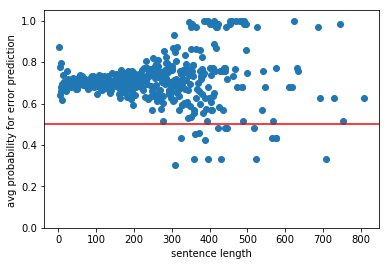

In [25]:
len_arr = []
prob_mean = []
for k, v in err_length_prob.iteritems():
    len_arr += [k]
    prob_mean += [np.mean(v)] 

plt.scatter(len_arr, prob_mean)
plt.axhline(y=0.5, color='r')
plt.xlabel('sentence length')
plt.ylabel('avg probability for error prediction ')
plt.ylim(ymin=0)
plt.show()


As you notice, shorter sentences (length < 200) has more consistent errors